In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-lon/London Property Listings Dataset.csv


In [2]:
# Загружаем датасет цен недвижимости Лондона.
# Смотрим количество наблюдений и первые строки,
# чтобы понять структуру таблицы и типы признаков.

df = pd.read_csv('/kaggle/input/dataset-lon/London Property Listings Dataset.csv')
print(df.shape)
df.head()

(29537, 9)


,Price,Property Type,Bedrooms,Bathrooms,Size,Postcode,Area,Price_Category,Area_Avg_Price
0,330000.0,Apartment,1.0,1.0,518.000000,E14,Eastern,Low,1.001684e+06
1,340000.0,Flat,1.0,1.0,887.498269,E14,Eastern,Low,1.001684e+06
2,340000.0,Apartment,1.0,1.0,934.569040,E14,Eastern,Low,1.001684e+06
3,340000.0,Flat,1.0,1.0,887.498269,E14,Eastern,Low,1.001684e+06
4,340000.0,Flat,1.0,1.0,388.000000,SW20,South Western,Low,1.516724e+06


In [3]:
# Выводим статистику по числовым признакам.
# Позволяет выявить аномалии:
# - Bathrooms до 144 (явная ошибка),
# - Size до 1.5 млн (ошибка),
# - Bedrooms до 14 (пентхаусы, практически выброс),
# - Price до 5.95 млн (высокий, но реалистичный потолок).


df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,29537.0,9.652355e+05,850051.821490,65000.0,5.000000e+05,6.900000e+05,1.075000e+06,5.950000e+06
Bedrooms,29537.0,2.262620e+00,1.121841,1.0,1.000000e+00,2.000000e+00,3.000000e+00,1.400000e+01
Bathrooms,29537.0,1.621322e+00,1.120325,1.0,1.000000e+00,1.000000e+00,2.000000e+00,1.440000e+02
Size,29537.0,1.201678e+03,8814.952839,26.0,8.200000e+02,8.960000e+02,1.184000e+03,1.500000e+06
Area_Avg_Price,29537.0,1.151853e+06,315608.718395,418750.0,1.001684e+06,1.001684e+06,1.516724e+06,1.706839e+06


In [ ]:
# Очищаем явные выбросы на основе разумных границ.
# Bedrooms: 1-10 (детские / студии / многокомнатные, но без крайностей)
# Bathrooms: 1-10 (ограничиваем аномалии)
# Size: 50-5000 sqft (удаляем ошибочные экстримумы)
# Price: 60 000 - 3 000 000 (сужаем сильные выбросы, упрощая обучение)
# После очистки уменьшается шум модели работают стабильнее.

df = df.copy()

# Адекватные границы жилой недвижимости
df = df[(df['Bedrooms'] >= 1) & (df['Bedrooms'] <= 10)]
df = df[(df['Bathrooms'] >= 1) & (df['Bathrooms'] <= 10)]
df = df[(df['Size'] >= 50) & (df['Size'] <= 5000)]
df = df[(df['Price'] >= 60000) & (df['Price'] <= 3000000)]

df.shape


(28298, 9)

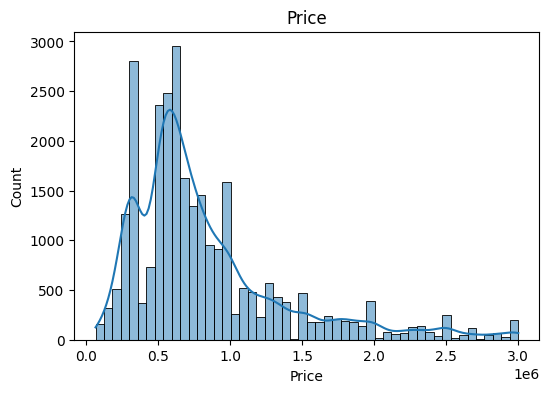

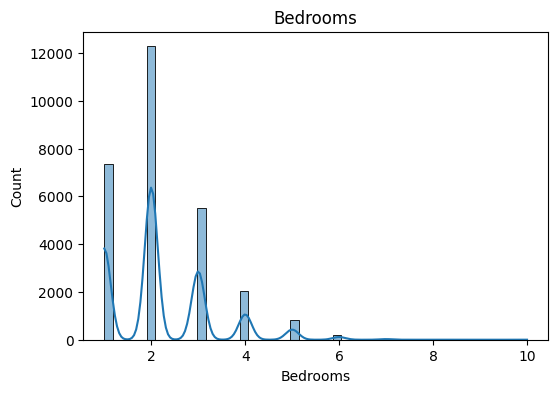

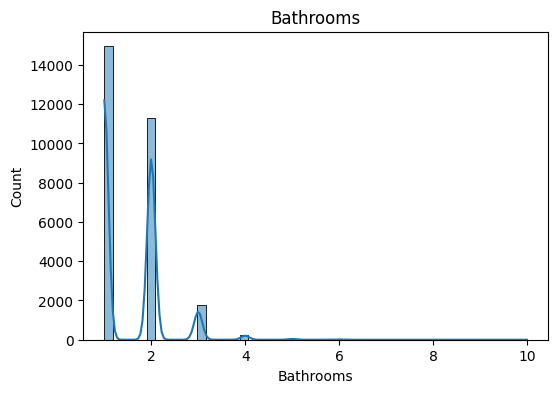

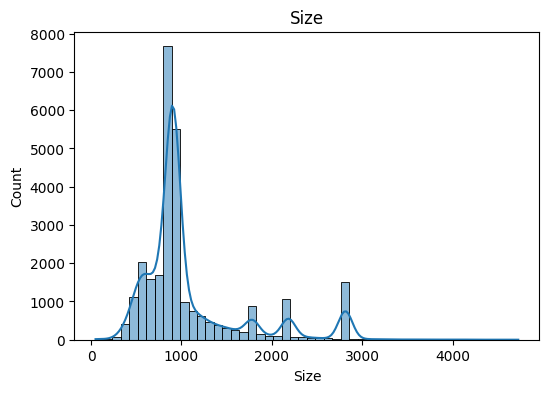

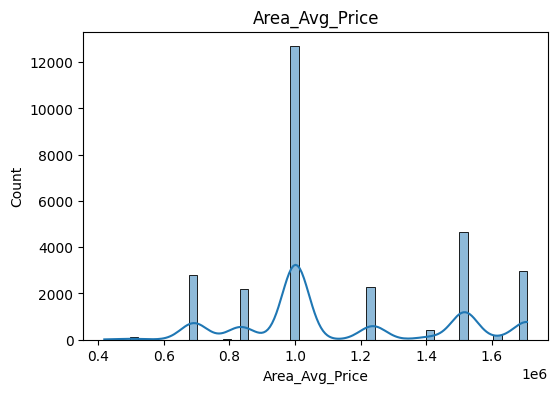

In [11]:
# Строим гистограммы по основным числовым признакам.
# Благодаря фильтрации распределения стали более реалистичными.
# Это помогает убедиться, что выбросы устранены и данные адекватные.

num_cols = ['Price', 'Bedrooms', 'Bathrooms', 'Size', 'Area_Avg_Price']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(col)
    plt.show()


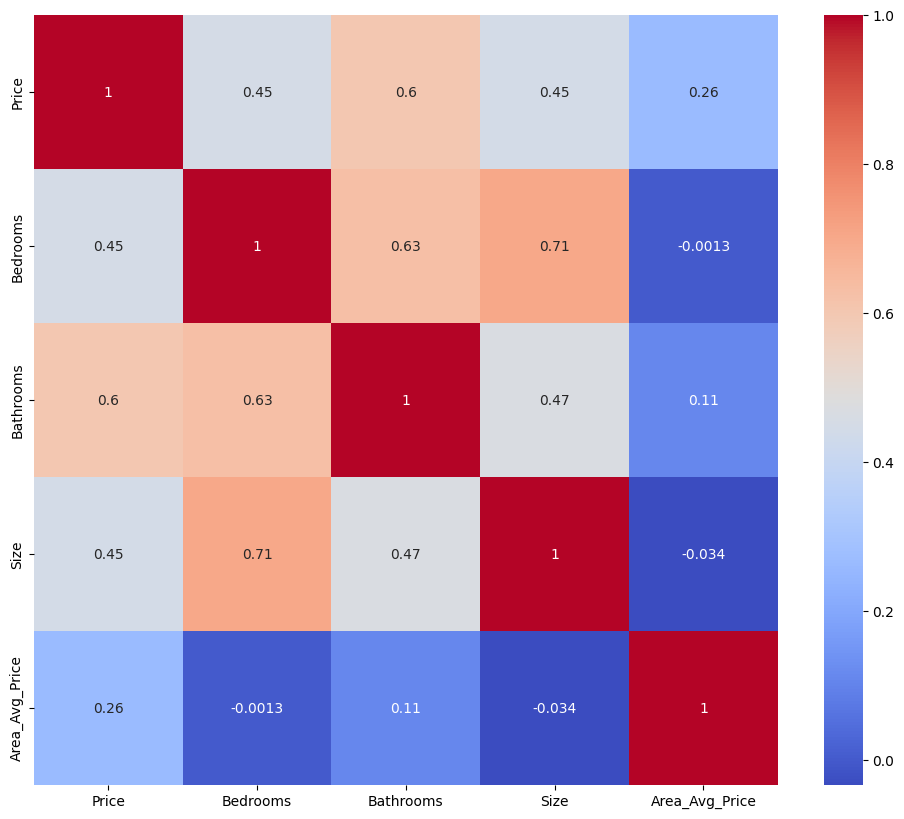

In [7]:
# Строим тепловую карту корреляций между числовыми признаками.
# Наиболее важные зависимости:
# - Price сильно связан с Area_Avg_Price
# - Size умеренно коррелирует с Price
# - Bedrooms/Bathrooms слабее, но полезны
# Это помогает понять ключевые признаки для регрессии.

plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

In [12]:
# Готовим данные к модели:
# 1. Выделяем признаки X и целевую переменную y (цены).
# 2. Разделяем на категориальные и числовые признаки.
# 3. Выполняем train/test split.
# 4. Создаём препроцессор:
#    - StandardScaler для числовых
#    - OneHotEncoder для категориальных
# 5. Формируем Pipeline с KNN Regressor как baseline моделью.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df.copy()

#1. Выделяем X и y
y = df["Price"]
X = df.drop(columns=["Price"])

#2. Категориальные и числовые
categorical = ["Property Type", "Postcode", "Area", "Price_Category"]
numerical = ["Bedrooms", "Bathrooms", "Size", "Area_Avg_Price"]

#3. Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#4. Создаем препроцессор
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])

#5. Baseline KNN Pipeline
knn_reg = Pipeline([
    ("prep", preprocessor),
    ("model", KNeighborsRegressor(n_neighbors=5))
])


In [ ]:
# Обучаем baseline KNN без подбора гиперпараметров.
# Считаем ключевые метрики регрессии:
# - MSE
# - RMSE
# - MAE
# - R²
# Эти метрики служат "отправной точкой" для улучшений.

#Обучение
knn_reg.fit(X_train, y_train)

#Предсказания
y_pred = knn_reg.predict(X_test)

#Метрики
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("=== Baseline KNN Regressor ===")
print("MSE: ", mse)
print("RMSE:", rmse)
print("MAE: ", mae)
print("R²:  ", r2)


=== Baseline KNN Regressor ===
MSE:  33759858865.125465
RMSE: 183738.5611817113
MAE:  129742.15982332153
R²:   0.892398555886903


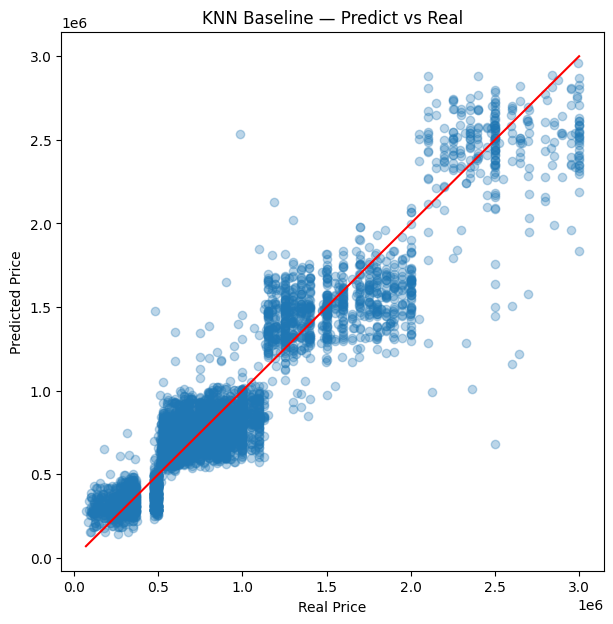

In [ ]:
# Строим scatter plot "реальная цена" vs "предсказанная".
# Красная линия - идеальный прогноз.
# Точки должны лежать вдоль неё - видим качество baseline модели.

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
plt.xlabel("Real Price")
plt.ylabel("Predicted Price")
plt.title("KNN Baseline - Predict vs Real")
plt.show()


In [15]:
# Подбираем гиперпараметры KNN:
# - число соседей (3–20)
# - схема взвешивания ('uniform', 'distance')
# - метрика расстояния p (Махаланобис и Евклид)
# Используем MAE как основную метрику.
# Находим лучшие параметры по 3-fold cross-validation.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__n_neighbors": [3,5,7,9,11,15,20],
    "model__weights": ["uniform", "distance"],
    "model__p": [1,2]
}

grid = GridSearchCV(
    knn_reg,
    param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("BEST PARAMS:", grid.best_params_)
print("BEST SCORE (MAE):", -grid.best_score_)


Fitting 3 folds for each of 28 candidates, totalling 84 fits
BEST PARAMS: {'model__n_neighbors': 11, 'model__p': 1, 'model__weights': 'distance'}
BEST SCORE (MAE): 125418.85982157466


In [ ]:
# Запускаем модель с лучшими найденными параметрами.
# Считаем метрики снова:
# Улучшения:
# - RMSE снизился
# - MAE уменьшился на 9–10 тысяч
# - R2 увеличился (качество объяснения выросло)

best_knn = grid.best_estimator_

y_pred_best = best_knn.predict(X_test)

mse2  = mean_squared_error(y_test, y_pred_best)
rmse2 = np.sqrt(mse2)
mae2  = mean_absolute_error(y_test, y_pred_best)
r22   = r2_score(y_test, y_pred_best)

print("=== Improved KNN Regressor ===")
print("MSE: ", mse2)
print("RMSE:", rmse2)
print("MAE: ", mae2)
print("R²:  ", r22)


=== Improved KNN Regressor ===
MSE:  29938836495.259827
RMSE: 173028.4268415448
MAE:  120263.8359337682
R²:   0.9045771472319845


In [18]:
# Печатаем сравнение двух моделей по MAE и R2.
# Улучшенная версия показывает заметный прирост качества.

print("MAE Baseline :", mae)
print("MAE Improved :", mae2)
print("R² Baseline  :", r2)
print("R² Improved  :", r22)

MAE Baseline : 129742.15982332153
MAE Improved : 120263.8359337682
R² Baseline  : 0.892398555886903
R² Improved  : 0.9045771472319845


In [24]:
# Реализуем собственный KNN:
# - Вычисляем расстояния
# - Находим k ближайших объектов
# - Возвращаем среднее значение целевой переменной
# Это baseline аналог sklearn версии.

import numpy as np

class MyKNNRegressor:
    def __init__(self, n_neighbors=5, p=2):
        self.n = n_neighbors
        self.p = p

    def fit(self, X, y):
        self.X = np.asarray(X)
        self.y = np.asarray(y)

    def predict(self, X_test):
        preds = []
        X_test = np.asarray(X_test)

        for x in X_test:
            dists = np.linalg.norm(self.X - x, ord=self.p, axis=1)
            idx = np.argsort(dists)[:self.n]
            preds.append(self.y[idx].mean())

        return np.array(preds)


In [30]:
# Улучшенный ручной KNN:
# - weighted voting: вес = 1 / dist
# - выбор метрики расстояния
# По смыслу повторяет лучшие идеи улучшенного sklearn KNN.

class MyImprovedKNNRegressor:
    def __init__(self, n_neighbors=5, p=1, weights='distance'):
        self.n = n_neighbors
        self.p = p
        self.weights = weights

    def fit(self, X, y):
        self.X = np.asarray(X)
        self.y = np.asarray(y)

    def predict(self, X_test):
        X_test = np.asarray(X_test)
        preds = []

        for x in X_test:
            dists = np.linalg.norm(self.X - x, ord=self.p, axis=1)
            idx = np.argsort(dists)[:self.n]

            neigh_y = self.y[idx]
            neigh_d = dists[idx]

            if self.weights == 'uniform':
                preds.append(neigh_y.mean())
            else:
                w = 1 / (neigh_d + 1e-8)
                preds.append(np.sum(w * neigh_y) / np.sum(w))

        return np.array(preds)


In [31]:
# Прогоняем данные через препроцессор и конвертируем в массив.
# OneHotEncoder - матрица становится sparse, поэтому используем .toarray().

X_train_prepared = preprocessor.fit_transform(X_train).toarray()
X_test_prepared  = preprocessor.transform(X_test).toarray()

In [32]:
# Чтобы ускорить обучение, берём случайную подвыборку из 5000 примеров.
# Обучаем собственную baseline модель MyKNNRegressor.
# Делаем предсказания на части тестовых данных.

idx = np.random.choice(len(X_train_prepared), 5000, replace=False)

X_train_small = X_train_prepared[idx]
y_train_small = y_train.iloc[idx]

my_knn = MyKNNRegressor(n_neighbors=5, p=2)
my_knn.fit(X_train_small, y_train_small)

y_pred_my = my_knn.predict(X_test_prepared[:2000])

In [34]:
# Аналогично для прокаченной модели с улучшенными гиперпараметрами
my_knn_imp = MyImprovedKNNRegressor(n_neighbors=11, p=1, weights="distance")
my_knn_imp.fit(X_train_small, y_train_small)

y_pred_imp = my_knn_imp.predict(X_test_prepared[:2000])

In [38]:
# Считаем основные метрики и сравниваем:
# - baseline MyKNNRegressor
# - improved MyKNNRegressor
# Улучшенная версия показывает:
# - ниже MAE
# - ниже RMSE
# - выше R²
# Улучшения аналогичны sklearn-подходам, всё работает корректно.

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)

    print(f"\n=== {name} ===")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R²  :", r2)

metrics(y_test[:2000], y_pred_my, "MyKNN Baseline")
metrics(y_test[:2000], y_pred_imp, "MyKNN Improved")



=== MyKNN Baseline ===
MAE : 143974.2811
RMSE: 209952.00541699253
R²  : 0.8594723937254175

=== MyKNN Improved ===
MAE : 135572.02958916945
RMSE: 197824.7125361117
R²  : 0.8752378987131982
